In [1]:
import torch
from model import GCN
# import sys
# sys.path.append("../../")
# from  utils import visualize_pyG

In [2]:
import os 
import random 
from natsort import natsorted

random.seed(42)
data_directory = "../../../training_data/data/task_from_graph_tensor/"
data_files = os.listdir(data_directory)
data_files = natsorted(data_files)
print(f"Lenght of data_files: {len(data_files)}")
print(f"First 10 data_fiels {data_files[:10]}")

list_of_iso_graphs = []
list_of_same_graphs = []
for idx, data_file in enumerate(data_files):
    data = torch.load(data_directory + data_file)
    if idx % 100 == 0 and idx != 0:
        list_of_iso_graphs.append(list_of_same_graphs.copy())
        list_of_same_graphs.clear()
        list_of_same_graphs.append(data)
    else: 
        list_of_same_graphs.append(data)

print(f"Length of list_of_iso_graphs: {len(list_of_iso_graphs)}")
print(f"length of each iso list : {len(list_of_iso_graphs[0])}")

Lenght of data_files: 81200
First 10 data_fiels ['graph_0.pt', 'graph_1.pt', 'graph_2.pt', 'graph_3.pt', 'graph_4.pt', 'graph_5.pt', 'graph_6.pt', 'graph_7.pt', 'graph_8.pt', 'graph_9.pt']
Length of list_of_iso_graphs: 811
length of each iso list : 100


In [3]:
import networkx as nx
from torch_geometric.utils import to_networkx

def check_iso(index_1, index_2):
    graph_1 = to_networkx(list_of_iso_graphs[index_1][random.randint(0, 99)])
    graph_2 = to_networkx(list_of_iso_graphs[index_2][random.randint(0, 99)])
    print(nx.is_isomorphic(graph_1, graph_2))

random_values_1 = [random.randint(0, 811) for _ in range(10)]
random_values_2 = [random.randint(0, 811) for _ in range(10)]

print(f"Random values 1 is {random_values_1}")
print(f"Random values 2 is {random_values_2}")

for rand_num in random_values_1:
    check_iso(rand_num, rand_num)

for rand_1, rand_2 in zip(random_values_1, random_values_2):
    check_iso(rand_1, rand_2)

Random values 1 is [654, 114, 25, 759, 281, 250, 228, 142, 754, 104]
Random values 2 is [692, 758, 558, 89, 604, 432, 32, 30, 95, 223]
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False


In [4]:
def do_inference(data, model_path):
    model_state_dict = torch.load(model_path,  map_location=torch.device('cpu'))
    model =  GCN().to(torch.device('cpu'))
    model.load_state_dict(model_state_dict)
    pred_latency = model(data.x, data.edge_index, data.batch)
    actual_latency = data.y
    model.load_state_dict(model_state_dict)
    return pred_latency, actual_latency

data = torch.load(f'{data_directory}graph_{random.randint(0,81200)}.pt')
pred, actual = do_inference(data, "LatNet_50_state_dict.pth")

print(f"Predicted latency: {pred}")
print(f"Actual latency: {actual}")

Predicted latency: tensor([[2135.7932]], grad_fn=<AddmmBackward0>)
Actual latency: tensor([2073.])


In [28]:
import numpy as np
import matplotlib.pyplot as plt

random.seed(102)
# random.seed(51)
num_of_test_data = 10
test_data = random.sample(list_of_iso_graphs, num_of_test_data)

pred_latency_list = []
list_of_latency_list = []
min_pred_latency_list = []

for idx, same_graphs in enumerate(test_data):
    latency_list = []
    to_infer = True
    for graph in same_graphs:
        latency_list.append(graph.y.item())
        if to_infer:
            pred, _ = do_inference(graph, "LatNet_200_state_dict.pth" )
            min_pred, _ = do_inference(graph, "../task_from_graph_min/LatNet_50_state_dict.pth" )

            pred_latency_list.append(pred.item())
            min_pred_latency_list.append(min_pred.item())
            to_infer = False

    list_of_latency_list.append(latency_list)

TypeError: 'Text' object is not callable

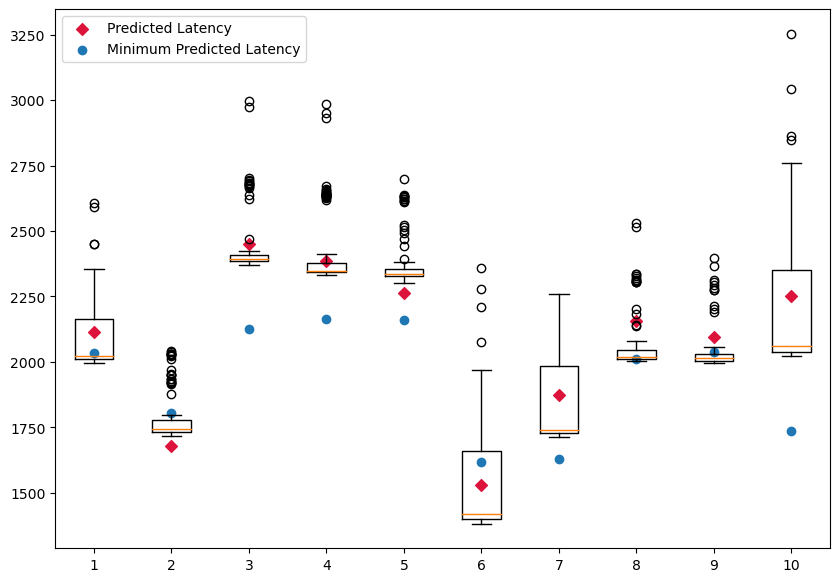

In [50]:

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(list_of_latency_list)

# ax.plot(np.arange(1, num_of_test_data + 1), pred_latency_list, color='lightgreen')
ax.scatter(np.arange(1, num_of_test_data + 1), pred_latency_list, color='crimson', marker='D', label='Predicted Latency')
ax.scatter(np.arange(1, num_of_test_data + 1), min_pred_latency_list, marker='o', label='Minimum Predicted Latency')
ax.legend()
ax.set_title('Boxplot of Latecy Distribution')
ax.set_xlabel('Distribution Index')
ax.set_ylabel('Latency')
# plt.show()

import tikzplotlib
tikzplotlib.save("boxplot.tex")